In [40]:
#ml 1 eda
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/27_problem1.csv")

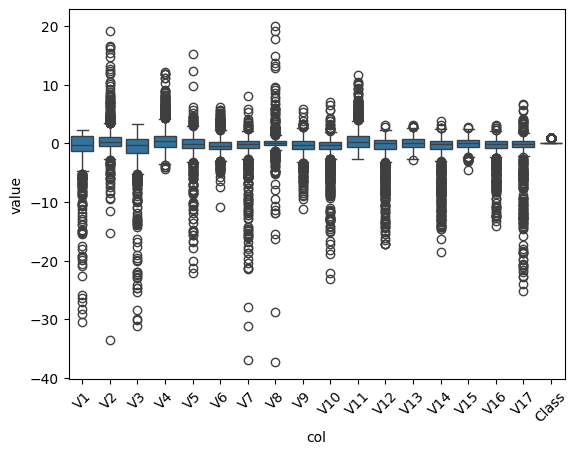

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

X=df.copy().drop(columns=['Time','Amount'])
y=df['Amount']
df_v1=pd.melt(X,var_name='col',value_name='value')
plt.figure()
sns.boxplot(x='col',y='value',data=df_v1)
plt.xticks(range(len(X.columns)),X.columns,rotation=45)
plt.show()# 많은 이상치 부분이 사기 부분일거라보임

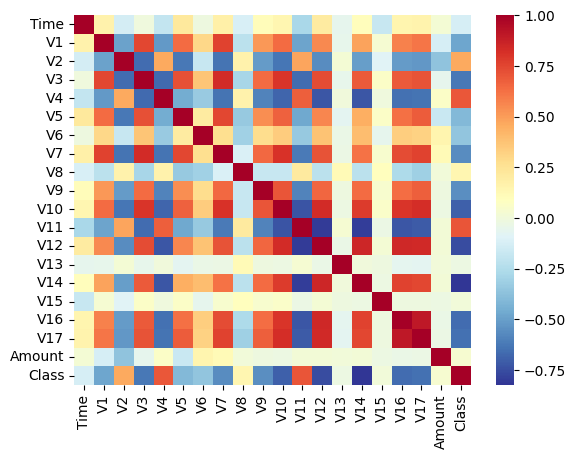

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig,ax= plt.subplots()

sns.heatmap(df.corr(),cmap='RdYlBu_r')
plt.show()

In [43]:
df['Class'].value_counts()
# 불균형으로 오버/언더 샘플링 필요 
# 변수간 상관관계 는 전문가 놀리지 필요
# amount는 다른 거랑 스케일차이가 커서 스케일링이 필욯

Class
0    993
1    200
Name: count, dtype: int64

In [44]:
# #2-1 차원 축소 방법 2가지 이상을 비교하고 한가지를 선택하시오
# FA. 요인분석 유사한 항목들끼리 묶어서 처리하는 기법, 이때는 독립 변수와 종속변수의 개념이 없으며, 모든 변수들 간의 관계를 분석함으로써 공통요인 ㅂ을 분석가의 판단으로 묶어서 처리할수 있다.
# PCA 주성분 분석 상솬성이 높은 변수들의 선형결합으로 이루어진 주성분이라는 ㅅ해로운 변수를 만들어 요약하고 축소하는 기법이다. 변수들의 성격을 알 수 없는 해당 데이터에 어울리는 분석은 pca 이다.

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1),copy=True)
scaled_amount=scaler.fit_transform(df[['Amount']])
df['Scaled_Amount']=scaled_amount

In [45]:
features=df.columns.drop(['Time','Class','Amount'])

In [46]:
from sklearn.decomposition import PCA

pca=PCA(n_components=len(features))
pca_fit=pca.fit(df[features])
print("고유값",pca_fit.singular_values_)
print("분산설명력",pca_fit.explained_variance_ratio_)

고유값 [313.34445642 108.1494526   88.31656842  75.95550775  74.04174398
  54.38022362  48.53052166  44.43119733  42.88301542  41.22188826
  40.02461796  37.7240559   35.89894925  34.29952844  33.25124613
  30.10449767  28.27817612   2.39049112]
분산설명력 [6.63121024e-01 7.89946023e-02 5.26784682e-02 3.89643386e-02
 3.70255949e-02 1.99724225e-02 1.59066485e-02 1.33329054e-02
 1.24199371e-02 1.14763697e-02 1.08193995e-02 9.61137507e-03
 8.70386688e-03 7.94557011e-03 7.46731749e-03 6.12084716e-03
 5.40071868e-03 3.85942881e-05]


In [47]:
pca_fit.singular_values_**2/np.sum(pca_fit.singular_values_**2)

array([6.63121024e-01, 7.89946023e-02, 5.26784682e-02, 3.89643386e-02,
       3.70255949e-02, 1.99724225e-02, 1.59066485e-02, 1.33329054e-02,
       1.24199371e-02, 1.14763697e-02, 1.08193995e-02, 9.61137507e-03,
       8.70386688e-03, 7.94557011e-03, 7.46731749e-03, 6.12084716e-03,
       5.40071868e-03, 3.85942881e-05])

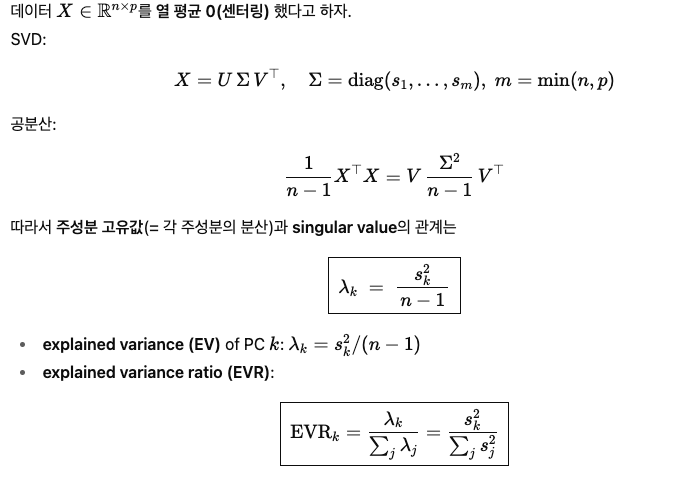
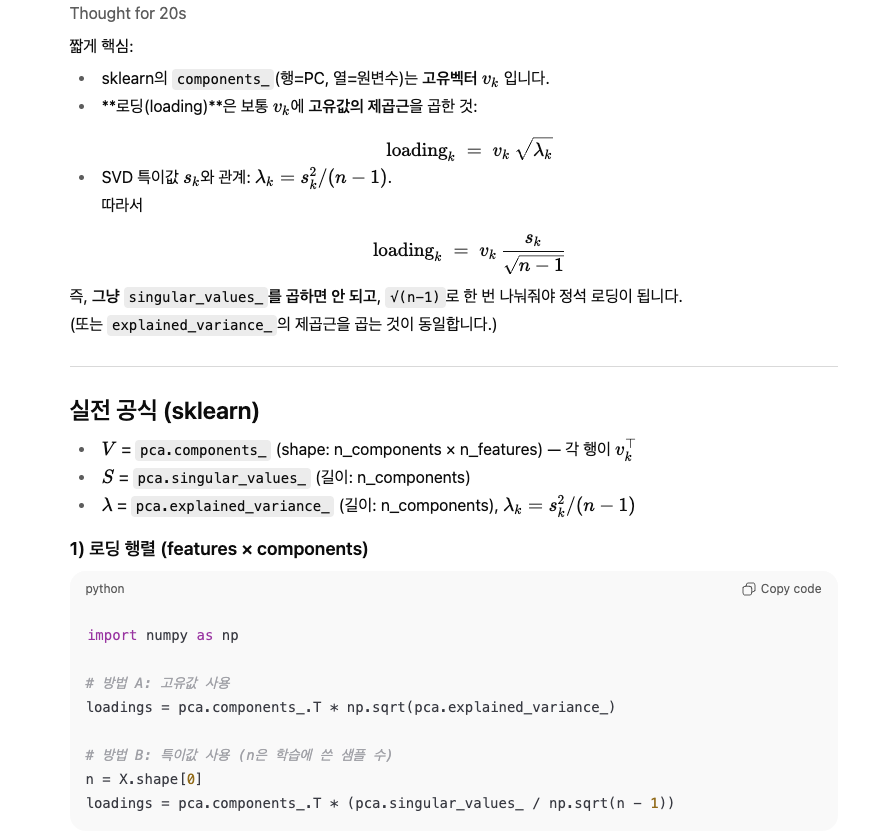

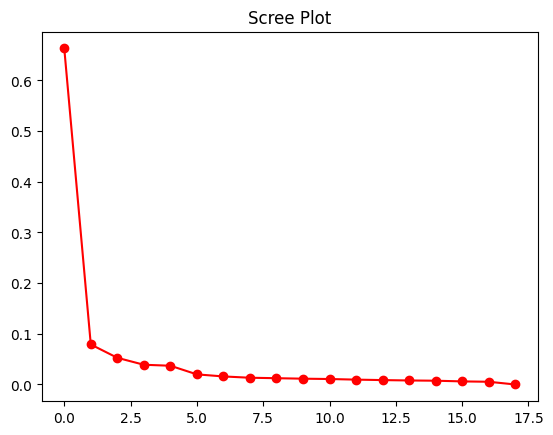

In [48]:
import matplotlib.pyplot as plt
plt.title('Scree Plot')
plt.plot(pca.explained_variance_ratio_,'ro-')

In [49]:
print('주성분 3개',np.sum(pca_fit.explained_variance_ratio_[:3]))
print('주성분 9개',np.sum(pca_fit.explained_variance_ratio_[:9]))

주성분 3개 0.7947940941729138
주성분 9개 0.9324159411774043


In [50]:
#3-1 오버샘플링과 언더 샘플링의 장단점 비교
# 언더 샘플링 할땐 데이터가 많이 날라가니깐 오버샘플링 할듯

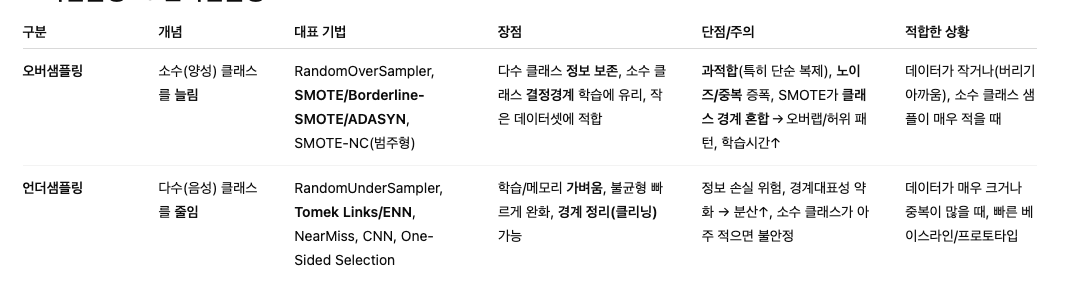

In [51]:
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# 1) Tomek Links만 사용(언더샘플/클리닝)
tl = TomekLinks(sampling_strategy="majority")  # "majority"만 제거 (기본적 선택)
# tl = TomekLinks(sampling_strategy="all")     # 양쪽 모두 제거(클리닝 강화)
X=df[features]
y=df['Class']
X_tl, y_tl = tl.fit_resample(X, y)
X_stl, y_stl = SMOTETomek(random_state=42).fit_resample(X,y)
# 2) 오버샘플링과 함께(권장 조합)
pipe = Pipeline([
    ("smote_tomek", SMOTETomek(random_state=42)),  # SMOTE(오버) + Tomek(클리닝)
    ("clf", RandomForestClassifier(random_state=42))
])
pipe.fit(X, y)
# 언제 쓰면 좋아?

# 경계가 들쭉날쭉하거나 노이즈가 많아 결정경계를 정리하고 싶을 때
# SMOTE 같은 오버샘플링 전/후에 경계 클리닝으로 조합할 때
# (대표 조합: SMOTE+Tomek = SMOTETomek, SMOTE+ENN)
# 단점/주의
# 샘플을 늘리지 않으므로 불균형 비율 자체는 크게 개선되지 않을 수 있음
# 클래스가 많이 겹치면 다수 샘플을 과도하게 삭제해 성능이 떨어질 수 있음
# 고차원에서 1-NN 품질이 떨어지면 효과가 약해짐

Pipeline(steps=[('smote_tomek', SMOTETomek(random_state=42)),
                ('clf', RandomForestClassifier(random_state=42))])

In [52]:
print(y.value_counts())
print(y_tl.value_counts())
print(y_stl.value_counts())

Class
0    993
1    200
Name: count, dtype: int64
Class
0    987
1    200
Name: count, dtype: int64
Class
0    992
1    992
Name: count, dtype: int64


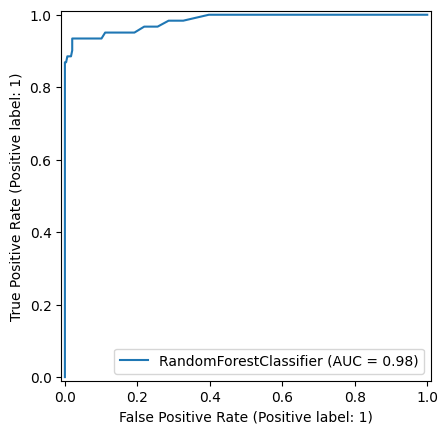

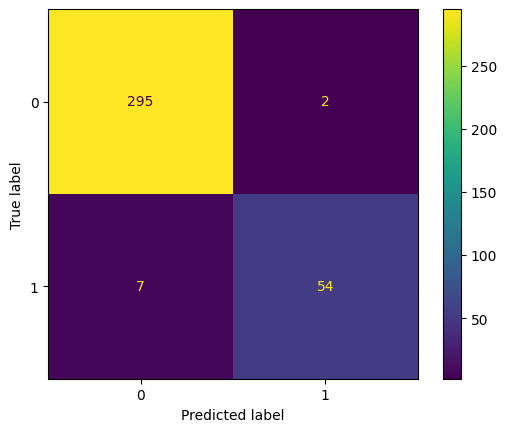

In [53]:
#3-2 분류 분석 구현 및 위에서 선택한 샘플링 기법중 2가지 이상의 알고리즘으로 모델을 비교하고 성능을 측정하시오
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
X=df[features]
y=df['Class']
X_train,X_test,Y_train,Y_test= train_test_split(X,y,test_size=0.3,random_state=23)
clf=RandomForestClassifier(random_state=32)
clf.fit(X_train,Y_train)
RocCurveDisplay.from_estimator(clf,X_test,Y_test)
# AUC 값이 0.96으로 굉장히 좋은 성능을 보이고 있다. 높을 수록 모델이 사기 와 ㄷ정상을 잘 구분한다느,ㄴ 것. 
# 데이터 불균형이 있을 경우 모든 ㅈ데이터를 정상으로 분류하여도 auc 의 값은 높아지게 된다. 
# 그러므로 오버 샘플링 언더 샘플링을 하여 모델의 정확도를 살펴볼필요가 있다.
ConfusionMatrixDisplay.from_predictions(Y_test,clf.predict(X_test))


In [54]:
print(classification_report(Y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       297
           1       0.96      0.89      0.92        61

    accuracy                           0.97       358
   macro avg       0.97      0.94      0.95       358
weighted avg       0.97      0.97      0.97       358



              precision    recall  f1-score   support

           0       0.98      0.99      0.98       297
           1       0.93      0.90      0.92        61

    accuracy                           0.97       358
   macro avg       0.96      0.94      0.95       358
weighted avg       0.97      0.97      0.97       358



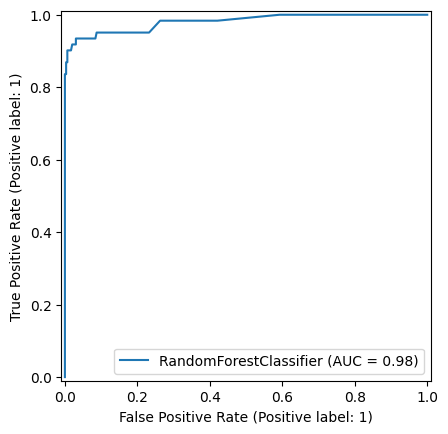

In [55]:
#샘플링 기법 2개 다적용 비교 

from imblearn.over_sampling import RandomOverSampler, SMOTE

X_resampled,Y_resampled = RandomOverSampler(random_state=1).fit_resample(X_train,Y_train)
clf_re=RandomForestClassifier(random_state=0)
clf_re.fit(X_resampled,Y_resampled)
print(classification_report(Y_test,clf_re.predict(X_test)))
RocCurveDisplay.from_estimator(clf_re,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       297
           1       0.92      0.92      0.92        61

    accuracy                           0.97       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.97      0.97      0.97       358



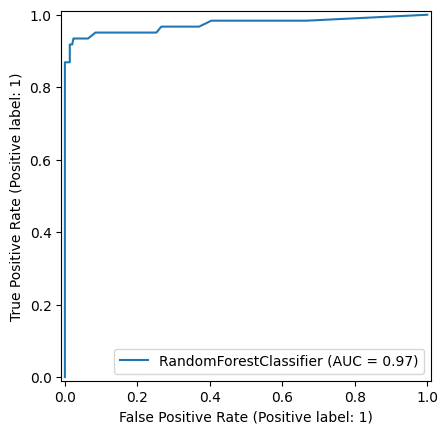

In [56]:
#샘플링 기법 2개 다적용 비교 
X_resampled,Y_resampled = SMOTE(k_neighbors=5,random_state=1).fit_resample(X_train,Y_train)
clf_re=RandomForestClassifier(random_state=0)
clf_re.fit(X_resampled,Y_resampled)
print(classification_report(Y_test,clf_re.predict(X_test)))
RocCurveDisplay.from_estimator(clf_re,X_test,Y_test)

In [57]:
#4 이상탐지모델 2가지 이상 서술하고 기술 장단점을 설명하시오

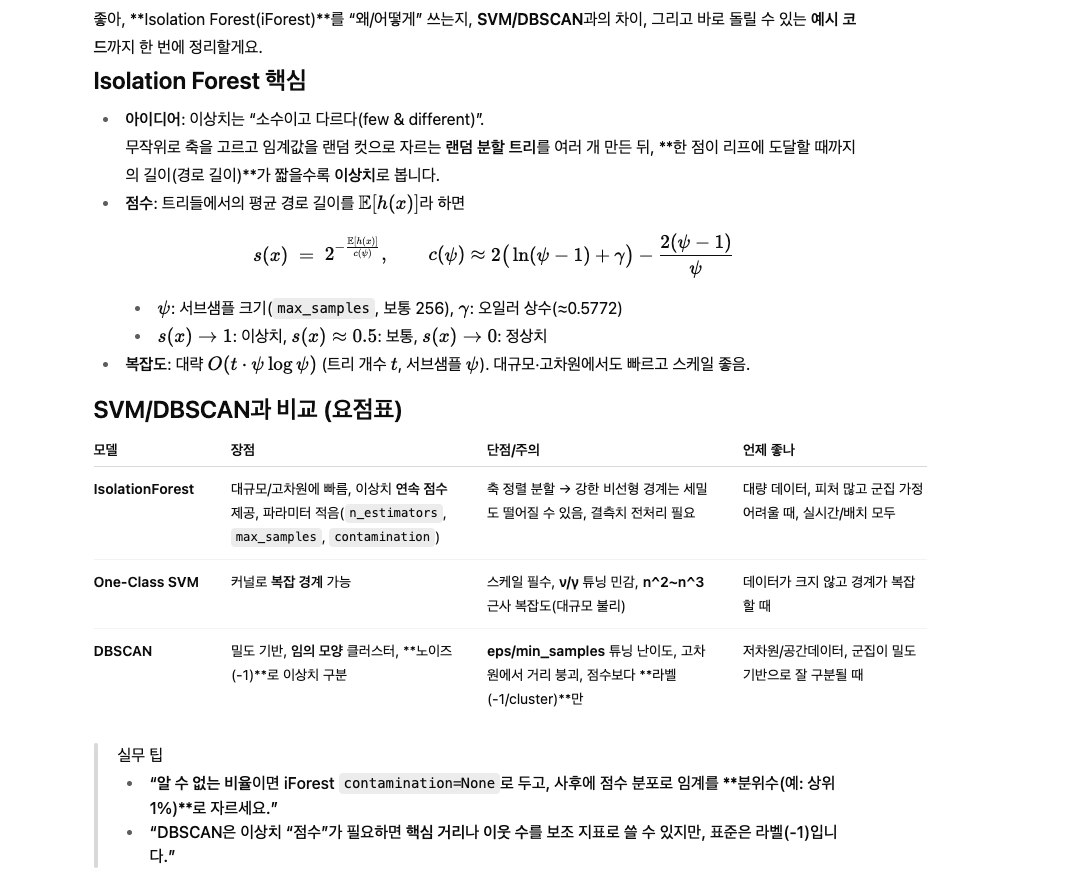

In [58]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# 예시 데이터: 정상 2개 군집 + 소수의 이상치
rng = np.random.RandomState(42)
X_normal = np.r_[rng.normal([0,0], 0.6, size=(600,2)),
                 rng.normal([4,4], 0.6, size=(400,2))]
X_out = rng.uniform(low=-6, high=8, size=(30,2))
X = np.vstack([X_normal, X_out])
y_true = np.hstack([np.zeros(len(X_normal), dtype=int), np.ones(len(X_out), dtype=int)])  # 1=이상치

# ---- 1) Isolation Forest ----
iso = IsolationForest(
    n_estimators=200,
    max_samples=256,         # 서브샘플 크기(기본 256)
    contamination=0.03,      # 이상치 비율 추정치 (모르면 None로 두고 따로 임계 설정)
    random_state=42,
    n_jobs=-1,
)
iso.fit(X)
pred_iso = iso.predict(X)              # {1: 정상, -1: 이상}
score_iso = -iso.decision_function(X)  # 클수록 이상치
y_pred_iso = (pred_iso == -1).astype(int)

print("[IsolationForest]")
print(classification_report(y_true, y_pred_iso, digits=3))

# ---- 2) One-Class SVM ----
scaler = StandardScaler()   # 스케일 강추
Xz = scaler.fit_transform(X)
ocsvm = OneClassSVM(kernel="rbf", gamma="scale", nu=0.03)  # nu≈이상치 상한
ocsvm.fit(Xz)
pred_svm = ocsvm.predict(Xz)            # {1: 정상, -1: 이상}
y_pred_svm = (pred_svm == -1).astype(int)

print("[OneClassSVM]")
print(classification_report(y_true, y_pred_svm, digits=3))

# ---- 3) DBSCAN (이상치 = noise = -1) ----
# eps/min_samples는 데이터 스케일에 민감 → 보통 표준화 후 튜닝
db = DBSCAN(eps=0.4, min_samples=5)     # 값은 데이터에 맞게 조정
lab = db.fit_predict(Xz)                 # {0,1,2,..., -1: 이상치}
y_pred_db = (lab == -1).astype(int)

print("[DBSCAN]")
print(classification_report(y_true, y_pred_db, digits=3))

# 임계값을 수동으로 정하고 싶을 때 (contamination 모를 때)
iso_nc = IsolationForest(contamination='auto', random_state=0).fit(X)
scores = -iso_nc.decision_function(X)
# 상위 2%를 이상치로:
thr = np.quantile(scores, 0.98)
y_pred_custom = (scores >= thr).astype(int)



[IsolationForest]
              precision    recall  f1-score   support

           0      0.994     0.993     0.993      1000
           1      0.774     0.800     0.787        30

    accuracy                          0.987      1030
   macro avg      0.884     0.897     0.890      1030
weighted avg      0.988     0.987     0.987      1030

[OneClassSVM]
              precision    recall  f1-score   support

           0      0.992     0.991     0.991      1000
           1      0.710     0.733     0.721        30

    accuracy                          0.983      1030
   macro avg      0.851     0.862     0.856      1030
weighted avg      0.984     0.983     0.984      1030

[DBSCAN]
              precision    recall  f1-score   support

           0      0.991     0.999     0.995      1000
           1      0.955     0.700     0.808        30

    accuracy                          0.990      1030
   macro avg      0.973     0.849     0.901      1030
weighted avg      0.990     0.990

In [59]:
# eps (ε): 반경. 한 점의 ε-이웃(그 원 안)에 몇 개나 이웃이 있느냐를 볼 때 쓰는 거리 임계값.
# min_samples (minPts): **핵심점(core)**로 인정받기 위한 최소 이웃 수(자기 자신 포함).
# scikit-learn DBSCAN의 기본은 metric='euclidean'이라면 유클리드 거리 반경이에요. 하지만 metric을 바꾸면 eps의 의미/단위도 그 거리 정의에 맞게 바뀝니다.
# 거리별로 eps가 의미하는 것
# Euclidean (기본):
# d(x,y)=∥x−y∥
# StandardScaler()로 표준화했다면 eps≈0.3~1.5 같은 무단위 값으로 튜닝합니다(데이터마다 다름).
# Minkowski(p=1,2,…): metric='minkowski', p=1은 맨해튼, p=2는 유클리드. eps는 해당 거리의 반경.
# Cosine: 𝑑cos⁡(𝑥,𝑦)=1−cos⁡𝜃dcos	​
# (x,y)=1−cosθ. eps=0.1 ↔ 코사인 유사도 ≥ 0.9 근처라는 뜻. (범위 대략 0~2, 보통 0에 가까운 값 사용)
# precomputed: 입력이 거리행렬이면 eps는 그 행렬 값(거리)에 대한 임계치 그대로.
# Haversine(위경도): 거리 단위가 라디안. 위경도를 라디안으로 넣고,
# eps = (원하는_km / 지구반경_km) 예) 1km → eps ≈ 1/6371 ≈ 0.000157.
# 실무 팁
# 스케일링 필수: 피처 단위가 다르면 유클리드 기준의 eps가 무의미해져요. 보통 StandardScaler로 표준화 후 튜닝.
# k-거리 플롯으로 eps 초기값: k=min_samples로 k-NN의 k번째 거리들을 정렬해 엘보우 지점 선택.
# 고차원/텍스트 등은 cosine이 더 낫기도 합니다.

features.drop("Scaled_Amount")
df_sample=df.sample(n=500)
df_sample=df_sample.drop(df_sample[df_sample["Class"]==1].index)
df_outlier=df[df["Class"]==1].sample(n=60)
df_sample_com=pd.concat([df_sample,df_outlier])
X_sp=df_sample_com[features]
Y_sp=df_sample_com["Class"]

In [75]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neigh=NearestNeighbors(n_neighbors=2)
nbrs=neigh.fit(X_sp)
dist,indices=nbrs.kneighbors(X_sp)

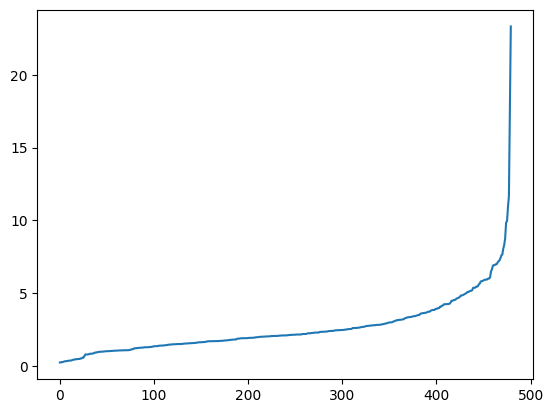

In [61]:
dist=np.sort(dist,axis=0)
dist= dist[:,1]
plt.figure()
plt.plot(dist)
# 엡실론의 최적값은 K 거리 그래프에서 최대 곡률 지점에 있으며 이경우 5로 지정한다. 
# 민 포인트는 2배인 10으로 적당히 

In [62]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
# 표준화 → 2) minPts ≈ d+1 ~ 2d로 시작 → 3) **k-거리(elbow)**로 ε 후보 → 4) **실루엣(노이즈 패널티)**로 미세 조정.
# ε↑는 합치고, minPts↑는 조밀만 살린다—이 감각으로 튜닝하면 됩니다.
def dbscan_eval(X, eps, min_samples, scale=True, metric="euclidean"):
    X_used = StandardScaler().fit_transform(X) if scale else X
    lab = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit_predict(X_used)
    mask = lab != -1
    n_noise = int((lab == -1).sum())
    n_eff = mask.sum()
    # 실루엣은 유효 클러스터가 2개 이상일 때만
    if n_eff > 1 and len(set(lab[mask])) > 1:
        sil = silhouette_score(X_used[mask], lab[mask], metric=metric)
        sil_adj = sil * (n_eff / len(lab))  # 노이즈 패널티(선택)
    else:
        sil, sil_adj = np.nan, np.nan
    return sil, sil_adj, n_noise, lab

def dbscan_grid(X, eps_list, minpts_list, scale=True, metric="euclidean"):
    rows = []
    for m in minpts_list:
        for e in eps_list:
            sil, sil_adj, n_noise, lab = dbscan_eval(X, e, m, scale, metric)
            rows.append({
                "minPts": m, "eps": e,
                "silhouette": sil, "silhouette_adj": sil_adj,
                "n_noise": n_noise,
                "n_clusters": len(set(lab)) - (1 if -1 in lab else 0),
            })
    df = pd.DataFrame(rows)
    # 실루엣(또는 패널티 포함)의 상위 조합을 확인
    score_col = "silhouette_adj" if df["silhouette_adj"].notna().any() else "silhouette"
    return df.sort_values(score_col, ascending=False, na_position="last").reset_index(drop=True)


In [63]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

db=DBSCAN(eps=6,min_samples=10).fit(X_sp)
label=db.labels_
data=pd.DataFrame()
data["Class"]=Y_sp.copy()
data["labels"]=label
data.loc[data['labels']==1,'Class'].sum()

11

In [65]:
# -1 은 사실 정상이지만 -1로 분류된경우가 많음
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics

data.loc[data.labels==-1,'labels']=1
confusion_matrix(data.Class,data.labels)
print(classification_report(data.Class,data.labels))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       420
           1       0.81      0.78      0.80        60

    accuracy                           0.95       480
   macro avg       0.89      0.88      0.88       480
weighted avg       0.95      0.95      0.95       480



In [66]:
# DBSCAN 4번 모델에서 라벨이 -1 이면서 클래스가 0 인 고객은 위험군으로 분류할 수 있다. 분류 정확도 만 보면 RF가 좋지만  여러케이스가 있을 경우 분류 해내기가 어렵다. 
# 하지만 DBSCAN 같은 거리기반 이상탐지는 정상으로 분류됮지않은 이상치를 가지고 위험ㅇ군을 관리할 수 있다.

In [67]:
# 통계 1 2년전 제품 생산량이 100000 1년전 생산량이 150000 그후 250000 되었을때 연평균 상승율의 개푯값을 구하시오
# 기하 평균 
import numpy as np 
prod_2y=100000
prod_1y=150000
prod_0y=250000
rt1=(prod_1y)/prod_2y
rt2=(prod_0y)/prod_1y
print(np.sqrt(rt1*rt2))


1.5811388300841898


In [68]:
# 통계 2 12건의 광과 시간을 측정한 데이터에서 평균은 15.5s 분산은 3.2s 였다 이때 광고 시간의 90% 신뢰구간은
from scipy import stats

mu=15.5
std=3.2**0.5
dof=12-1
print(stats.t.interval(confidence=0.9,loc=15.5, scale=std,df=dof))

(12.287423572494966, 18.71257642750503)


In [69]:
# 통계 3 강의 상류와 하류 생물 다양성 점수의 차이가 있는지 유의수준 0.1 이하 검정하시오 독립적이지 않고 종속적 관계 정규성만족
import pandas as pd
import numpy as np

df=pd.read_csv("https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/27_problem7.csv")

In [70]:
import scipy.stats as stats

stats.ttest_rel(df['up'],df['down'])#  0.1 이하 므로 기각

TtestResult(statistic=3.3526056764717995, pvalue=0.028499777234053288, df=4)

In [84]:
#통계 4 user_counts를 종속변수 
#4-1 분위수 회귀분석을 사용하여 쇠귀 계수를 구하시오
import pandas as pd 
import numpy as np
df_user=pd.read_csv("https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/27_problem8.csv")
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import train_test_split

X=df_user[[c for c in df_user.columns if c !='user_counts']]
y=df_user[[c for c in df_user.columns if c =='user_counts']]
X_train,X_test,Y_train,Y_test= train_test_split(X,y,test_size=.3,)
rgr=QuantileRegressor(quantile=0.5,fit_intercept=True)
rgr.fit(X_train,Y_train)
print(df_user.head(5))
print(rgr.coef_)
print(rgr.intercept_)
print(rgr.coef_[0]*10.5)
#QuantileRegressor는 “조건부 평균”이 아니라 **조건부 분위수(quantile)**를 직접 예측하는 선형 분위수 회귀입니다. 손실로 핀볼(pinball) 손실을 최소화하고, 기본적으로 **L1 정규화(라쏘식)**가 걸립니다.
#  그래서 **중앙값 회귀(τ=0.5)**나 상·하위 분위수를 바로 맞추어 예측 구간을 만들 때 유용하고, 평균 회귀보다 이상치에 더 견고합니다.
# τ를 여러 개(예: 0.05/0.95) 학습하면 95% 예측구간을 바로 얻습니다.
# QuantileRegressor(quantile=tau, alpha=1.0) 
# 2) 예측구간(분위수 밴드) 얻는 법
# from sklearn.linear import QuantileRegressor

# tau_lo, tau_hi = 0.05, 0.95
# qr_lo = QuantileRegressor(quantile=tau_lo, alpha=1.0).fit(X, y)
# qr_hi = QuantileRegressor(quantile=tau_hi, alpha=1.0).fit(X, y)

# y_lo  = qr_lo.predict(X_new)   # 5% 분위수 추정
# y_hi  = qr_hi.predict(X_new)   # 95% 분위수 추정
# → [y_lo, y_hi] 가 90% 예측구간 역할


   temperature   wind  precipitation  user_counts
0    10.400000  4.600       0.844944         6368
1     5.666667  4.625       0.040860         5902
2     4.933333  4.725       0.008696         6226
3     3.400000  2.675       0.156989         5829
4     8.900000  3.950       7.988462         7589
[208.22485207   0.           0.        ]
6125.627218934912
2186.3609467455617


/opt/homebrew/Caskroom/miniforge/base/envs/general/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [81]:
#5 지하철 호선과 월별 승갱 수간 상관관계가 있는지 확인하시오
#5-1 귀무가설과 대립가설을 설정하시오
# 상호 작용효과 가설
# 귀무 지하철 호선과 월별 승객 수 간 상관관계가 없다.
# 대립 지하철 호선과 월별 승객 수 간 상관관계가 있다.
# 주효과 가설 2개
# 귀무 지하철 호선 승객 수 차이는 존재하지 않는다. 
# 대립 지하철 호선 승객 수 차이는 존재한다.
# 귀무 월별 승객 수 차이는 존재하지 않는다.
# 대립 월별 승객 수 차이는 존재한다.

import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/27_problem9.csv")
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
fomula='total ~ C(line) + C(month) + C(line):C(month)' #fomula='total ~ C(line)*C(month)'
model=ols(fomula,df).fit()
anova_results=anova_lm(model)
print(anova_results)
# 전부 pvalue 가 0.05 이하로 귀무가설 기각 대립가설 채택
# 지하철 호선과 월별 승객 수 간 상관관계가 있다
# 지하철 호선 승객 수 차이는 존재한다.
# 월별 승객 수 차이는 존재한다.


                    df        sum_sq       mean_sq             F        PR(>F)
C(line)            2.0  2.147444e+06  1.073722e+06  10362.998525  2.007247e-50
C(month)          11.0  3.206533e+04  2.915030e+03     28.134341  2.103496e-14
C(line):C(month)  22.0  9.696908e+04  4.407686e+03     42.540665  1.582232e-19
Residual          36.0  3.730000e+03  1.036111e+02           NaN           NaN


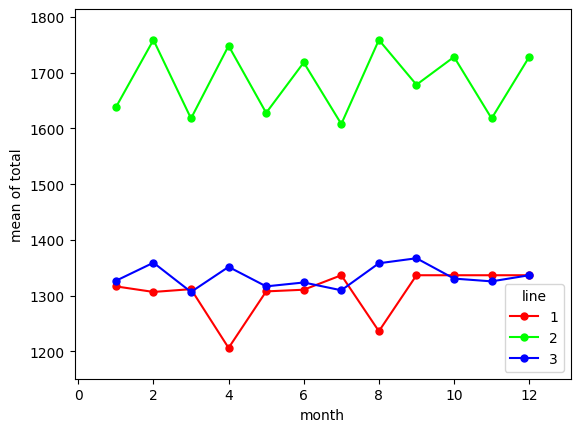

In [73]:
#타입3 아노바의 경우 아래의 시각화
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt

total=df['total']
line=df['line']
month=df['month']
fix,ax=plt.subplots()
fit=interaction_plot(month,line,total,ax=ax,ms=10)
# 달과 호선에 따라 승객수의 그래프가 교ㅕ차하는 지점이 없어 평행해야지 인터랙션이 없다고 할수 없지만, 
# 여러번 교차하므로 서로 상관이 있다.


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     1      2  379.4583    0.0  349.1273  409.7894   True
     1      3   27.7917 0.0792   -2.5394   58.1227  False
     2      3 -351.6667    0.0 -381.9977 -321.3356   True
---------------------------------------------------------
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2  47.8333   1.0 -332.1532 427.8199  False
     1      3    -15.0   1.0 -394.9865 364.9865  False
     1      4   8.3333   1.0 -371.6532 388.3199  False
     1      5  -9.6667   1.0 -389.6532 370.3199  False
     1      6  23.8333   1.0 -356.1532 403.8199  False
     1      7     -9.0   1.0 -388.9865 370.9865  False
     1      8     24.0   1.0 -355.9865 403.9865  False
     1      9  33.6667   1.0 -346.3199 413.6

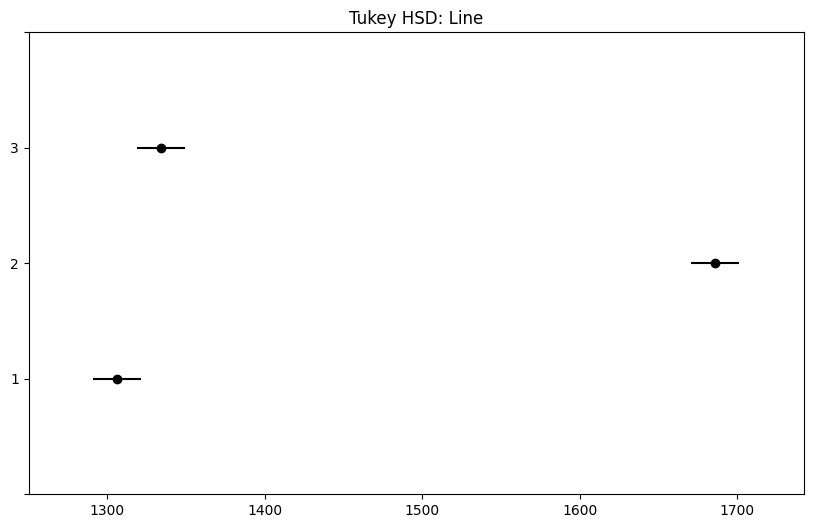

In [74]:

# --- 사후분석: Tukey HSD ---
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 예시: 호선별로 월별 승객수 차이 사후분석 (line 기준)
tukey_line = pairwise_tukeyhsd(df['total'], df['line'])
print(tukey_line)
# 월별로도 가능
tukey_month = pairwise_tukeyhsd(df['total'], df['month'])
print(tukey_month)

# 시각화(선택)
tukey_line.plot_simultaneous()
plt.title("Tukey HSD: Line")
plt.show()